# Pokigen
This code uses a beta variational auto encoder [B.1] to generate pokemon like images.

In [1]:
print("Using full network")
import sys
sys.path.append("../src")
#from cnn_beta_vae import CNNBetaVAE
from cnn_beta_vae_mobilenet import CNNBetaVAE
#from cnn_beta_vae_light import CNNBetaVAE

# Need matplotlib to plot some curves
import matplotlib.pyplot as plt
# Need opencv for image processing
import cv2

# Need to compute svd 
from scipy.linalg import svd

# Need to do a PCA on latent space
from sklearn.decomposition import PCA

# Ofcourse we need numpy
import numpy as np

Using full network


In [2]:
#Constants
latent_dim_size=27

Let's create the network

In [3]:
cnnbvae = CNNBetaVAE((128,128,3),latent_dim_size,2, model_weights_path="../models/model.h5")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
mobilenet_1.00_128 (Functional) (None, 4, 4, 1024)   3228864     input[0][0]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 16384)        0           mobilenet_1.00_128[0][0]         
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           262160      flatten[0][0]                    
____________________________________________________________________________________________

# Reloading weights (if not a new training)

In [28]:
# Load models if you want tyo start from previous training otherwize please skip
cnnbvae.load_weights("../models/model_weights.h5")

# Database import
If the database was not added to your dir. Please use those lines to download and install it.

This was tested on Ubuntu PC using bash shell.
If you are using windows, you may need to change some shell commands to dos style ones. 

In [6]:
# Download the pokemon database from rileynwong's github
!wget https://github.com/rileynwong/pokemon-images-dataset-by-type/archive/master.zip
# Extract and select the all subdatabase 
!unzip master.zip 
!mv pokemon-images-dataset-by-type-master/all ../database
# Remove resulting files
!rm -R pokemon-images-dataset-by-type-master
!rm master.zip

--2020-10-29 15:27:25--  https://github.com/rileynwong/pokemon-images-dataset-by-type/archive/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/rileynwong/pokemon-images-dataset-by-type/zip/master [following]
--2020-10-29 15:27:26--  https://codeload.github.com/rileynwong/pokemon-images-dataset-by-type/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

    [    <=>                                ] 5,227,888   6.89MB/s   in 0.7s   

2020-10-29 15:27:27 (6.89 MB/s) - ‘master.zip’ saved [5227888]

Archive:  master.zip
5efee999701bf26a73216c0f6f35aa9968cd1fd9
   creating: pokemon-images-dataset-by-type

  inflating: pokemon-images-dataset-by-type-master/all/claydol.png  
  inflating: pokemon-images-dataset-by-type-master/all/clefable.png  
  inflating: pokemon-images-dataset-by-type-master/all/clefairy.png  
  inflating: pokemon-images-dataset-by-type-master/all/cleffa.png  
  inflating: pokemon-images-dataset-by-type-master/all/cloyster.png  
 extracting: pokemon-images-dataset-by-type-master/all/cobalion.png  
 extracting: pokemon-images-dataset-by-type-master/all/cofagrigus.png  
  inflating: pokemon-images-dataset-by-type-master/all/combee.png  
 extracting: pokemon-images-dataset-by-type-master/all/combusken.png  
  inflating: pokemon-images-dataset-by-type-master/all/comfey.jpg  
  inflating: pokemon-images-dataset-by-type-master/all/conkeldurr.png  
  inflating: pokemon-images-dataset-by-type-master/all/corphish.png  
  inflating: pokemon-images-dataset-by-type-master/all/corsola.png  
  inflating: pokemon-images-dataset-by-type-master/all/cosmoem.jpg  
  inflating: pokemon-ima

 extracting: pokemon-images-dataset-by-type-master/all/garchomp.png  
 extracting: pokemon-images-dataset-by-type-master/all/gardevoir.png  
  inflating: pokemon-images-dataset-by-type-master/all/gastly.png  
  inflating: pokemon-images-dataset-by-type-master/all/gastrodon.png  
  inflating: pokemon-images-dataset-by-type-master/all/genesect.png  
  inflating: pokemon-images-dataset-by-type-master/all/gengar.png  
  inflating: pokemon-images-dataset-by-type-master/all/geodude.png  
  inflating: pokemon-images-dataset-by-type-master/all/gible.png  
  inflating: pokemon-images-dataset-by-type-master/all/gigalith.png  
  inflating: pokemon-images-dataset-by-type-master/all/girafarig.png  
 extracting: pokemon-images-dataset-by-type-master/all/giratina-altered.png  
  inflating: pokemon-images-dataset-by-type-master/all/glaceon.png  
  inflating: pokemon-images-dataset-by-type-master/all/glalie.png  
  inflating: pokemon-images-dataset-by-type-master/all/glameow.png  
  inflating: pokemon-

  inflating: pokemon-images-dataset-by-type-master/all/ledyba.png  
  inflating: pokemon-images-dataset-by-type-master/all/lickilicky.png  
  inflating: pokemon-images-dataset-by-type-master/all/lickitung.png  
 extracting: pokemon-images-dataset-by-type-master/all/liepard.png  
  inflating: pokemon-images-dataset-by-type-master/all/lileep.png  
  inflating: pokemon-images-dataset-by-type-master/all/lilligant.png  
  inflating: pokemon-images-dataset-by-type-master/all/lillipup.png  
  inflating: pokemon-images-dataset-by-type-master/all/linoone.png  
  inflating: pokemon-images-dataset-by-type-master/all/litleo.png  
  inflating: pokemon-images-dataset-by-type-master/all/litten.jpg  
  inflating: pokemon-images-dataset-by-type-master/all/litwick.png  
  inflating: pokemon-images-dataset-by-type-master/all/lombre.png  
 extracting: pokemon-images-dataset-by-type-master/all/lopunny.png  
  inflating: pokemon-images-dataset-by-type-master/all/lotad.png  
  inflating: pokemon-images-datas

 extracting: pokemon-images-dataset-by-type-master/all/palkia.png  
  inflating: pokemon-images-dataset-by-type-master/all/palossand.jpg  
  inflating: pokemon-images-dataset-by-type-master/all/palpitoad.png  
  inflating: pokemon-images-dataset-by-type-master/all/pancham.png  
  inflating: pokemon-images-dataset-by-type-master/all/pangoro.png  
  inflating: pokemon-images-dataset-by-type-master/all/panpour.png  
  inflating: pokemon-images-dataset-by-type-master/all/pansage.png  
  inflating: pokemon-images-dataset-by-type-master/all/pansear.png  
  inflating: pokemon-images-dataset-by-type-master/all/paras.png  
  inflating: pokemon-images-dataset-by-type-master/all/parasect.png  
  inflating: pokemon-images-dataset-by-type-master/all/passimian.jpg  
  inflating: pokemon-images-dataset-by-type-master/all/patrat.png  
  inflating: pokemon-images-dataset-by-type-master/all/pawniard.png  
  inflating: pokemon-images-dataset-by-type-master/all/pelipper.png  
  inflating: pokemon-images-d

  inflating: pokemon-images-dataset-by-type-master/all/shelmet.png  
  inflating: pokemon-images-dataset-by-type-master/all/shieldon.png  
  inflating: pokemon-images-dataset-by-type-master/all/shiftry.png  
  inflating: pokemon-images-dataset-by-type-master/all/shiinotic.jpg  
  inflating: pokemon-images-dataset-by-type-master/all/shinx.png  
  inflating: pokemon-images-dataset-by-type-master/all/shroomish.png  
  inflating: pokemon-images-dataset-by-type-master/all/shuckle.png  
  inflating: pokemon-images-dataset-by-type-master/all/shuppet.png  
 extracting: pokemon-images-dataset-by-type-master/all/sigilyph.png  
  inflating: pokemon-images-dataset-by-type-master/all/silcoon.png  
  inflating: pokemon-images-dataset-by-type-master/all/silvally.jpg  
  inflating: pokemon-images-dataset-by-type-master/all/simipour.png  
 extracting: pokemon-images-dataset-by-type-master/all/simisage.png  
  inflating: pokemon-images-dataset-by-type-master/all/simisear.png  
  inflating: pokemon-image

  inflating: pokemon-images-dataset-by-type-master/all/tynamo.png  
  inflating: pokemon-images-dataset-by-type-master/all/type-null.jpg  
 extracting: pokemon-images-dataset-by-type-master/all/typhlosion.png  
 extracting: pokemon-images-dataset-by-type-master/all/tyranitar.png  
  inflating: pokemon-images-dataset-by-type-master/all/tyrantrum.png  
  inflating: pokemon-images-dataset-by-type-master/all/tyrogue.png  
  inflating: pokemon-images-dataset-by-type-master/all/tyrunt.png  
  inflating: pokemon-images-dataset-by-type-master/all/umbreon.png  
 extracting: pokemon-images-dataset-by-type-master/all/unfezant.png  
  inflating: pokemon-images-dataset-by-type-master/all/unown.png  
 extracting: pokemon-images-dataset-by-type-master/all/ursaring.png  
  inflating: pokemon-images-dataset-by-type-master/all/uxie.png  
  inflating: pokemon-images-dataset-by-type-master/all/vanillish.png  
  inflating: pokemon-images-dataset-by-type-master/all/vanillite.png  
  inflating: pokemon-image

 extracting: pokemon-images-dataset-by-type-master/bug/scyther.png  
  inflating: pokemon-images-dataset-by-type-master/bug/sewaddle.png  
  inflating: pokemon-images-dataset-by-type-master/bug/shedinja.png  
  inflating: pokemon-images-dataset-by-type-master/bug/shelmet.png  
  inflating: pokemon-images-dataset-by-type-master/bug/shuckle.png  
  inflating: pokemon-images-dataset-by-type-master/bug/silcoon.png  
  inflating: pokemon-images-dataset-by-type-master/bug/spewpa.png  
  inflating: pokemon-images-dataset-by-type-master/bug/spinarak.png  
  inflating: pokemon-images-dataset-by-type-master/bug/surskit.png  
  inflating: pokemon-images-dataset-by-type-master/bug/swadloon.png  
  inflating: pokemon-images-dataset-by-type-master/bug/venipede.png  
  inflating: pokemon-images-dataset-by-type-master/bug/venomoth.png  
  inflating: pokemon-images-dataset-by-type-master/bug/venonat.png  
  inflating: pokemon-images-dataset-by-type-master/bug/vespiquen.png  
  inflating: pokemon-images

  inflating: pokemon-images-dataset-by-type-master/electric/zebstrika.png  
  inflating: pokemon-images-dataset-by-type-master/electric/zeraora.png  
   creating: pokemon-images-dataset-by-type-master/fairy/
  inflating: pokemon-images-dataset-by-type-master/fairy/aromatisse.png  
  inflating: pokemon-images-dataset-by-type-master/fairy/clefable.png  
  inflating: pokemon-images-dataset-by-type-master/fairy/clefairy.png  
  inflating: pokemon-images-dataset-by-type-master/fairy/cleffa.png  
  inflating: pokemon-images-dataset-by-type-master/fairy/comfey.png  
  inflating: pokemon-images-dataset-by-type-master/fairy/flabebe.png  
  inflating: pokemon-images-dataset-by-type-master/fairy/floette.png  
 extracting: pokemon-images-dataset-by-type-master/fairy/florges.png  
  inflating: pokemon-images-dataset-by-type-master/fairy/granbull.png  
  inflating: pokemon-images-dataset-by-type-master/fairy/slurpuff.png  
  inflating: pokemon-images-dataset-by-type-master/fairy/snubbull.png  
  inf

 extracting: pokemon-images-dataset-by-type-master/ghost/giratina-altered.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/gourgeist-average.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/haunter.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/lampent.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/litwick.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/mimikyu.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/misdreavus.png  
 extracting: pokemon-images-dataset-by-type-master/ghost/mismagius.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/palossand.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/phantump.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/pumpkaboo-average.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/sandygast.png  
  inflating: pokemon-images-dataset-by-type-master/ghost/shuppet.png  
  inflating: pokemon-images-dataset-by

  inflating: pokemon-images-dataset-by-type-master/ground/marowak.png  
  inflating: pokemon-images-dataset-by-type-master/ground/mudbray.png  
  inflating: pokemon-images-dataset-by-type-master/ground/mudsdale.png  
  inflating: pokemon-images-dataset-by-type-master/ground/phanpy.png  
  inflating: pokemon-images-dataset-by-type-master/ground/rhydon.png  
  inflating: pokemon-images-dataset-by-type-master/ground/rhyhorn.png  
  inflating: pokemon-images-dataset-by-type-master/ground/rhyperior.png  
  inflating: pokemon-images-dataset-by-type-master/ground/sandile.png  
  inflating: pokemon-images-dataset-by-type-master/ground/sandshrew.png  
  inflating: pokemon-images-dataset-by-type-master/ground/sandslash.png  
  inflating: pokemon-images-dataset-by-type-master/ground/stunfisk.png  
  inflating: pokemon-images-dataset-by-type-master/ground/trapinch.png  
  inflating: pokemon-images-dataset-by-type-master/ground/vibrava.png  
   creating: pokemon-images-dataset-by-type-master/ice/
 

  inflating: pokemon-images-dataset-by-type-master/normal/stoutland.png  
  inflating: pokemon-images-dataset-by-type-master/normal/stufful.png  
  inflating: pokemon-images-dataset-by-type-master/normal/swablu.png  
  inflating: pokemon-images-dataset-by-type-master/normal/swellow.png  
  inflating: pokemon-images-dataset-by-type-master/normal/taillow.png  
  inflating: pokemon-images-dataset-by-type-master/normal/tauros.png  
  inflating: pokemon-images-dataset-by-type-master/normal/teddiursa.png  
  inflating: pokemon-images-dataset-by-type-master/normal/toucannon.png  
  inflating: pokemon-images-dataset-by-type-master/normal/tranquill.png  
  inflating: pokemon-images-dataset-by-type-master/normal/trumbeak.png  
  inflating: pokemon-images-dataset-by-type-master/normal/type-null.png  
 extracting: pokemon-images-dataset-by-type-master/normal/unfezant.png  
 extracting: pokemon-images-dataset-by-type-master/normal/ursaring.png  
  inflating: pokemon-images-dataset-by-type-master/no

  inflating: pokemon-images-dataset-by-type-master/water/mantyke.png  
  inflating: pokemon-images-dataset-by-type-master/water/marill.png  
  inflating: pokemon-images-dataset-by-type-master/water/marshtomp.png  
  inflating: pokemon-images-dataset-by-type-master/water/milotic.png  
  inflating: pokemon-images-dataset-by-type-master/water/mudkip.png  
  inflating: pokemon-images-dataset-by-type-master/water/octillery.png  
  inflating: pokemon-images-dataset-by-type-master/water/oshawott.png  
 extracting: pokemon-images-dataset-by-type-master/water/palkia.png  
  inflating: pokemon-images-dataset-by-type-master/water/palpitoad.png  
  inflating: pokemon-images-dataset-by-type-master/water/panpour.png  
  inflating: pokemon-images-dataset-by-type-master/water/pelipper.png  
  inflating: pokemon-images-dataset-by-type-master/water/phione.png  
  inflating: pokemon-images-dataset-by-type-master/water/piplup.png  
  inflating: pokemon-images-dataset-by-type-master/water/politoed.png  
  

In [6]:
# The database is ready, let's load it and preprocess it
db = "../database"
# Load training/validation database and preprocess it
images, pokemons_files = cnnbvae.load_images(db, return_image_file_names=True)
# Preprocess data
images = cnnbvae.preprocess_images(images)

In [7]:
def show_photos(img_vals, image_names, nb_columns=4, figsize=(10,20), max_nbphotos=12):
    fig = plt.figure(figsize=figsize)
    nb_rows = len(image_names)//nb_columns+1

    if len(image_names)>max_nbphotos:
        nb_files= max_nbphotos
    else:
        nb_files=len(image_names)

    for i in range(nb_files):
        img =plt.subplot(nb_files,nb_columns,i+1)
        img.imshow((img_vals[i,:,:]))
        img.set_title(image_names[i])
    plt.tight_layout()

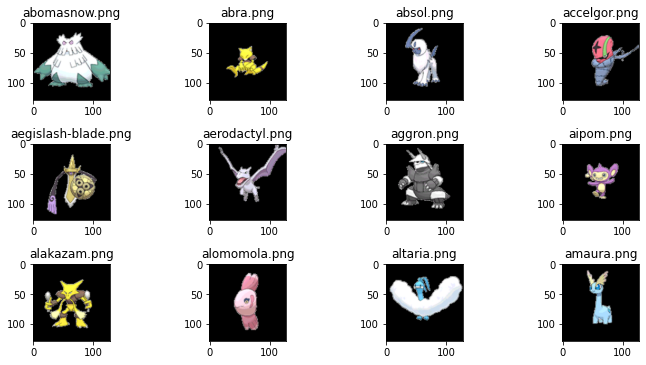

In [8]:
show_photos(images, pokemons_files)

In [6]:
print(images.dtype)
cnnbvae.learn(images,100)

float32
Fitting auto encoder
Train on 647 samples, validate on 162 samples
Epoch 1/100
647/647 [==============================] - ETA: 0s - loss: 15223.0994WARNING:tensorflow:From /home/aloui/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
647/647 [==============================] - 214s 331ms/sample - loss: 15223.0994 - val_loss: 15759.2966
Epoch 2/100
647/647 [==============================] - 211s 326ms/sample - loss: 10657.6716 - val_loss: 6658.7734
Epoch 3/100
647/647 [==============================] - 218s 337ms/sample - loss: 7432.9044 - val_loss: 5015.4366
Epoch 4/100
647/647 [==============================] - 212s 328ms/sample - loss: 11442.3259 - val_loss: 1858.6012
Epoch 5/100
647/647 [=================

KeyboardInterrupt: 

Text(0.5, 1.0, 'Loss curves')

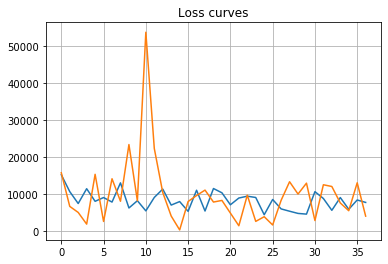

In [8]:
plt.figure()
plt.grid()
plt.plot(cnnbvae.loss_buffer, label="Loss")
plt.plot(cnnbvae.val_loss_buffer, label="Validation Loss")
plt.title("Loss curves")
plt.savefig("../figures/{}_loss".format())

In [29]:
out = cnnbvae.predict(images)

0.36819854
0.003925932


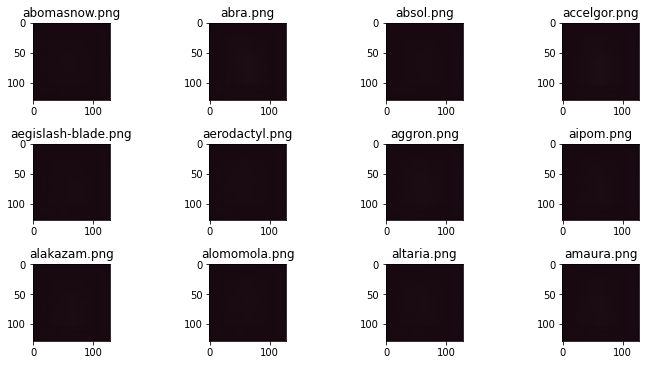

In [32]:
print(out.max())
print(out.min())
out_images = cnnbvae.postprocess_outputs(out).astype(np.int)
show_photos(out, pokemons_files)#


In [11]:
encoded = cnnbvae.encoder.predict(images)[0]

In [12]:
# We find out a new subspace where the spreading is maximum 
pca = PCA(2)
projected=pca.fit_transform(encoded)

(809, 27)


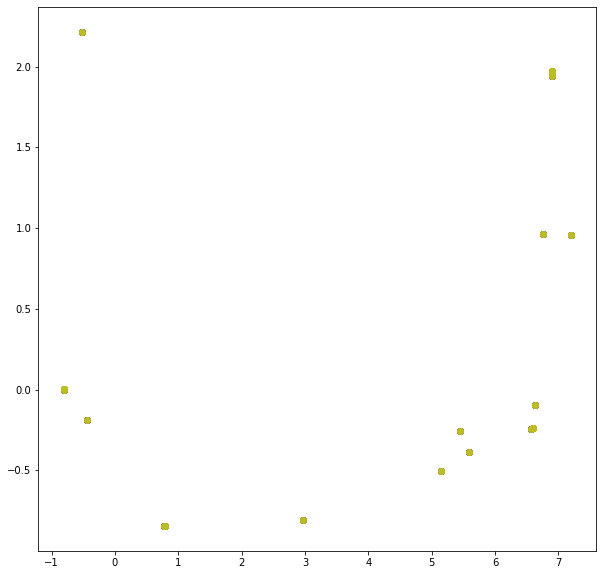

In [13]:
fig = plt.figure(figsize=(10,10))
print(encoded.shape)
for i in range(len(pokemons_files)):
    plt.scatter(projected[:,0],projected[:,1])

In [14]:
v = np.var(out, axis=0)
print(v)

[[[3.88083654e-03 4.66040382e-03 8.46918738e-06]
  [9.64597519e-03 7.73101160e-03 1.62695860e-03]
  [7.44060241e-03 1.22526577e-02 1.63435622e-03]
  ...
  [1.10916537e-03 8.04461166e-03 1.94369373e-03]
  [2.19739112e-03 4.56270576e-03 1.92858570e-03]
  [1.17628151e-04 1.22828339e-03 1.15877157e-03]]

 [[7.39077432e-03 9.99057107e-03 1.48574007e-04]
  [3.64524722e-02 1.20385895e-02 1.13926018e-02]
  [1.87295917e-02 1.58117842e-02 8.10509920e-03]
  ...
  [6.15880033e-03 1.00185554e-02 1.20678963e-02]
  [1.79736279e-02 7.52624962e-03 1.54720023e-02]
  [1.21339843e-04 1.65762991e-04 3.64552834e-03]]

 [[9.83609166e-03 1.22350035e-02 2.22344045e-03]
  [3.88177931e-02 1.96970645e-02 1.81935485e-02]
  [2.05853563e-02 2.72410139e-02 1.72979049e-02]
  ...
  [3.89447692e-03 2.10889392e-02 2.15570237e-02]
  [1.57815237e-02 1.66220311e-02 2.24698726e-02]
  [1.19362972e-04 2.37137452e-03 7.76309334e-03]]

 ...

 [[1.19077484e-03 1.83982134e-03 9.69588757e-04]
  [2.61285212e-02 8.33506696e-03 1.4649

In [15]:
U,s,vh = svd(encoded)
selection=s/s.max()*100 
print(selection[selection>10])
print(selection[selection>10].shape)

[100.        27.396673]
(2,)


[0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


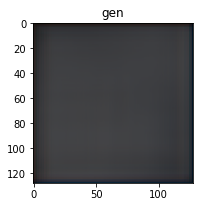

In [16]:
a = [0.2]+[0]*(latent_dim_size-1)
print(a)
img = cnnbvae.decoder.predict(np.array(np.reshape(a,(1,latent_dim_size))))
show_photos(img, ["gen"])

RuntimeError: Requested MovieWriter (ffmpeg) not available

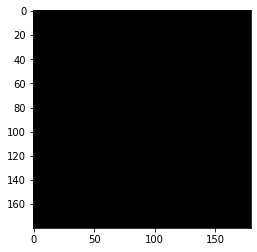

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML


# Now let's sample this subspace
rn = np.arange(-10,10,0.1)
rn1 = np.arange(-10,10,0.1)
latent = np.zeros((rn.shape[0],2))
latent[:,0]=rn1
latent[:,1]=rn

# Getback to full space
full_latent  = pca.inverse_transform(latent)

# Now predict
im = cnnbvae.decoder.predict(full_latent)

fig, ax = plt.subplots()

line = ax.imshow(np.zeros((180,180,3)))
# initialization function: plot the background of each frame
def init():
    line.set_data(np.zeros((180,180,3)))
    return (line,)

def animate(i):
    line.set_data(im[i,:,:,:]/im[i,:,:,:].max())
    return (line,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=im.shape[0], interval=200, blit=True)
HTML(anim.to_html5_video())



In [18]:
bvae.save("../models/model_final.h5")

# Bibliography
 - B.1 Higgins, I. et al. “beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework.” ICLR (2017).